In [1]:
import torch
torch.set_default_dtype(torch.float64)

In [2]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')

In [4]:
from modules.model_training import train_and_predict_single_gp
from modules.fusion_methods import compute_neg_log_like
from modules.model_training import GPModel, to_torch, train_variational_gp, predict_variational_gp


from tqdm import tqdm

from gpytorch.means import ZeroMean
from gpytorch.kernels import AdditiveStructureKernel, RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.metrics import mean_standardized_log_loss

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [5]:
import imageio.v2 as imageio
import imageio as iio
 
X_train = []
# read an image 
for i in 1+np.arange(12000):
    img = iio.imread(f"/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_train/{i}.jpg")
    X_train.append(img)

X_train = np.array(X_train)    
X_train = X_train.reshape(12000,28*28)
X_train.shape

/var/folders/b6/z4591_kn5dz7xy81wtgqr67c0000gp/T/ipykernel_23533/4241675017.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread(f"/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_train/{i}.jpg")


(12000, 784)

In [6]:
X_test = []
# read an image 
for i in 1+np.arange(800):
    img = iio.imread(f"/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_test/{i}.jpg")
    X_test.append(img)

X_test = np.array(X_test)    
X_test = X_test.reshape(800,28*28)
X_test.shape

/var/folders/b6/z4591_kn5dz7xy81wtgqr67c0000gp/T/ipykernel_23533/236637803.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread(f"/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_test/{i}.jpg")


(800, 784)

In [7]:
# Normalize data
X_train = X_train/255.0 
X_test = X_test/255.0 

# mean_x = np.mean(X_train,axis=0,keepdims=True)
# std_x = np.std(X_train,axis=0,keepdims=True)

# X_train = (X_train - mean_x)/std_x
# X_test = (X_test - mean_x)/std_x

In [8]:
import pandas as pd

file = "/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_train/train_list.txt"
df = pd.read_csv(file, header=None, delimiter=' ') # or quotechar = "'"
y_train = np.array(df[1])

file = "/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_test/test_list.txt"
df = pd.read_csv(file, header=None, delimiter=' ') # or quotechar = "'"
y_test = np.array(df[1])

In [9]:
y_train.shape, y_test.shape
meanY = np.mean(y_train)
stdY = np.std(y_train)

In [10]:
# Normalize data
y_train = (y_train - meanY)/stdY
y_test = (y_test - meanY)/stdY

In [11]:
print(X_train.max(),X_test.max())
print(y_train.mean(), y_test.mean())
print(y_train.std(), y_test.std())

1.0 1.0
-7.105427357601002e-18 -0.011693234372475953
0.9999999999999999 1.0026059874361415


In [12]:
np.random.seed(666)
indices = np.random.choice(len(X_train),100)
X_train = X_train[indices]
y_train = y_train[indices]
X_train.shape,y_train.shape

((100, 784), (100,))

# SV-GP (with rbf or additive kernel)

In [48]:
from gpytorch.kernels import AdditiveStructureKernel, RBFKernel, ScaleKernel

# Fit a GP with ARD-RBF kernel as the baseline
inducing_points = X_train[:len(X_train)]
# kernel = AdditiveStructureKernel(base_kernel=ScaleKernel(RBFKernel()), 
#                                              num_dims=X_train.shape[1])
kernel = ScaleKernel(RBFKernel(ard_num_dims=X_train.shape[1]))
model,likelihood = train_variational_gp(X_train, y_train, inducing_points, 
                                        learning_rate = 0.01, batch_size=X_train.shape[1], num_epochs=1000, 
                                        kappa=10, lambdaa = 5, kernel=kernel)

mean_tr,std_tr = predict_variational_gp(model, likelihood, X_train)
mean_tst,std_tst = predict_variational_gp(model, likelihood, X_test)


print("NLPD train: ", compute_neg_log_like(mean_tr,std_tr,y_train))
print("NLPD test: ", compute_neg_log_like(mean_tst,std_tst,y_test))

print("rmse train: ", np.sqrt(np.mean((y_train.squeeze() - mean_tr.squeeze())**2)))
print("rmse test: ", np.sqrt(np.mean((y_test.squeeze() - mean_tst.squeeze())**2)))

NLPD train:  [-0.35432484]
NLPD test:  [0.78268397]
rmse train:  0.06643377954909617
rmse test:  0.5155615104166219


# full GP with rbf kernel

In [49]:
test_preds,train_preds = train_and_predict_single_gp(X_train,y_train,X_test,X_train,training_iter=1000,lr=0.01, initialiaze_hyper=False)

mean_tr, std_tr = train_preds.mean.numpy(),np.sqrt(train_preds.variance.numpy())
mean_tst, std_tst = test_preds.mean.numpy(),np.sqrt(test_preds.variance.numpy())


print("NLPD train: ", compute_neg_log_like(mean_tr,std_tr,y_train))
print("NLPD test: ", compute_neg_log_like(mean_tst,std_tst,y_test))

print("rmse train: ", np.sqrt(np.mean((y_train.squeeze() - mean_tr.squeeze())**2)))
print("rmse test: ", np.sqrt(np.mean((y_test.squeeze() - mean_tst.squeeze())**2)))

NLPD train:  [-1.81887744]
NLPD test:  [0.84076842]
rmse train:  0.003551382126313107
rmse test:  0.5386467179753586


# full GP with additive kernel

In [15]:
kernel = AdditiveStructureKernel(base_kernel=ScaleKernel(RBFKernel()), 
                                             num_dims=X_train.shape[1])
test_preds,train_preds = train_and_predict_single_gp(X_train,y_train,X_test,X_train,
                                                     training_iter=1000,lr=0.1, initialiaze_hyper=False,
                                                     kernel=kernel)

mean_tr, std_tr = train_preds.mean.numpy(),np.sqrt(train_preds.variance.numpy())
mean_tst, std_tst = test_preds.mean.numpy(),np.sqrt(test_preds.variance.numpy())


print("NLPD train: ", compute_neg_log_like(mean_tr,std_tr,y_train))
print("NLPD test: ", compute_neg_log_like(mean_tst,std_tst,y_test))

print("rmse train: ", np.sqrt(np.mean((y_train.squeeze() - mean_tr.squeeze())**2)))
print("rmse test: ", np.sqrt(np.mean((y_test.squeeze() - mean_tst.squeeze())**2)))

NLPD train:  [0.62018358]
NLPD test:  [0.83339415]
rmse train:  0.37764346207487853
rmse test:  0.5224256263516717


# Joint learning with jax

In [16]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad, lax
from jax.scipy.linalg import cho_factor, cho_solve
import optax
from functools import partial


#%% Auxiliary functions
vmatmul = jax.vmap(lambda A,B: (A @ B), in_axes=(0, 0))

def transform(raw_param, fun = "softplus"):               # raw_param lives in (-inf,inf)
    if fun == "exp":
        param = jnp.exp(raw_param)                      # exponential
    elif fun == "softplus":
        param = jnp.log(1 + jnp.exp(raw_param))         # softplus
    else:
        raise ValueError("Transform function not implemented.")
    return param        # param lives in (0,inf)  

def inv_transform(cons_param, fun = "invsoftplus"):          # cons_param lives in (0,inf)
    if fun == "log":
        param = jnp.log(cons_param)                          #  log   
    elif fun == "invsoftplus":
        param = jnp.log(jnp.exp(cons_param) - 1)             # inverse softplus
    else:
        raise ValueError("Inverse transform function not implemented.")
    return param       # param lives in (-inf,inf) 



# Efficient kernel matrix computation using vmap
def kernel_matrix(X1, X2, length_scale, variance, noise, include_noise = True):
    pairwise_sqdists = jnp.sum(
        ((X1[:, None, :] - X2[None, :, :]) / jnp.broadcast_to(length_scale, X1[:, None, :].shape)) ** 2, 
        axis=-1)
    K = variance * jnp.exp(-0.5 * pairwise_sqdists)
    if include_noise:
        K += noise * jnp.eye(X1.shape[0])
    return K

# Compute alpha and diagonal elements of the inverse of K using Cholesky
def compute_alpha_and_diag_inv_K(K_chol, y):
    alpha = cho_solve((K_chol, True), y)
    
    compute_diag = jax.vmap(lambda A, b, i: cho_solve((A, True), b)[i], in_axes=(None, 0, 0))
    diag_inv_K = compute_diag(K_chol, jnp.eye(K_chol.shape[0]), jnp.arange(K_chol.shape[0])) 
    
    return alpha, diag_inv_K


# Function to make predictions with the optimized GPs and projections
def predict_fused_gp_with_projs(X_train, y_train, X_test, length_scales, variances, noises, weights):
    def gp_predict(X_train,X_test,length_scale, variance, noise):
        K = kernel_matrix(X_train, X_train, length_scale, variance, noise)
        K_s = kernel_matrix(X_test, X_train, length_scale, variance, noise, include_noise=False)
        K_ss = kernel_matrix(X_test, X_test, length_scale, variance, noise)
        
        K_chol = cho_factor(K, lower=True)[0]
        
        alpha = cho_solve((K_chol, True), y_train)
        v = cho_solve((K_chol, True), K_s.T)
        
        mu_s = K_s @ alpha
        cov_s = K_ss - K_s @ v
        
        return mu_s, jnp.diag(cov_s)
    
    mus, covs = vmap(gp_predict)(X_train,X_test,length_scales, variances, noises)  # we also vmap training and test datasets
    
    weighted_vars_inv = weights[:, None] / covs
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * mus, axis=0)
    
    return fused_means, fused_vars



def save_results(results, filename):
    with open(filename, 'wb') as f:
        pickle.dump(results, f)


# %% # ======== (3) WITH projections AND PRE-projections ========== #

def loo_cv_objective_3(params, X, y, M,proj_dim, dim, normalize_weights=False, proj_seed = 42):
    N,_ = X.shape

    length_scales_raw = lax.dynamic_slice(params, (0,), (dim,)).reshape((dim))  # these are lengthscales for PRE-projection; experts have no lengthscales
    variances_raw = lax.dynamic_slice(params, (dim,), (M,))
    noises_raw = lax.dynamic_slice(params, (M + dim,), (M,))
    weights_raw = lax.dynamic_slice(params, (M * 2 + dim,), (M,))
  
    length_scales, variances, noises = transform(length_scales_raw), transform(variances_raw), transform(noises_raw)
    weights = transform(weights_raw)
    if normalize_weights:
        weights = weights / jnp.sum(weights)

    X_reps = jnp.tile(jnp.expand_dims(X,0), (M,1,1))
    P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,dim, proj_dim))/jnp.sqrt(proj_dim)   

    X_projs = vmatmul(X_reps, P_projs/ length_scales[None, :, None])
    assert (length_scales[None, :, None] * P_projs).shape == P_projs.shape
    assert X_projs.shape == (M,N,proj_dim)

    
    def gp_loops(X,length_scale, variance, noise):
        K = kernel_matrix(X, X, length_scale, variance, noise)
        K_chol = cho_factor(K, lower=True)[0]
        alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)
        
        loo_means = y - alpha / diag_inv_K
        loo_vars = 1 / diag_inv_K
        
        return loo_means, loo_vars
    
    loo_means, loo_vars = vmap(gp_loops)(X_projs, jnp.ones_like(variances), variances, noises) # We set experts' lengthscales to 1
    
    # Fuse the means and variances using the product rule with weights
    weighted_vars_inv = weights[:, None] / loo_vars
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * loo_means, axis=0)
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(fused_vars.squeeze()) + \
                                      (y.squeeze() - fused_means.squeeze())**2 / fused_vars.squeeze())
    
    return -loo_cv_log_score  # Negative for minimization


# JIT compile the objective function for faster optimization
loo_cv_objective_3_jit = jit(loo_cv_objective_3, static_argnames=['M','proj_dim',"dim","normalize_weights"])


def optimize_objective(obj_fun_jit,init_params,static_argnames,lr = 0.1, num_steps=100, **kwargs):
    # **kwargs should contain all parameters needed by the objective that are not being optimized, namely, contained in params

    # Define the optimizer
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(init_params)

    # Define the update step
    @partial(jax.jit, static_argnames=static_argnames)
    def update(params, opt_state,**kwargs):
        loss, grads = value_and_grad(obj_fun_jit)(params, **kwargs)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    # Training loop
    params = init_params
    losses = []
    for step in tqdm(range(num_steps)):
        loss, params, opt_state = update(params, opt_state, **kwargs)
        losses.append(loss)
        # if step % 100 == 0 or step == num_steps-1:
        #     print(f"Step {step}, Loss: {loss}")

    # Get the optimized parameters
    return params, losses

## with pre-projections

In [17]:
DIM = X_train.shape[1]

M = 20
proj_dim = DIM//20
proj_seed = 20  # seed of the random projection
init_params = jnp.concatenate(
    (
        1.0 * jnp.ones((DIM,)),  # lengthscales
        1.0 * jnp.ones((M,)),  # variances
        0.5 * jnp.ones((M,)),  # noises
        jnp.ones((M,)),  # weights
    ),
)
init_params = inv_transform(init_params)

other_params = {'X': X_train,
                'y': y_train,
                'M': M,
                'proj_dim': proj_dim,
                'dim': DIM,
                'normalize_weights': True,
                'proj_seed': proj_seed,
                }
static_argnames = ['M', 'proj_dim', 'dim', 'normalize_weights']

params, losses = optimize_objective(loo_cv_objective_3_jit, 
                                                init_params, 
                                                static_argnames,
                                                lr=0.1, 
                                                num_steps=100,
                                                **other_params)

# Get the optimized parameters
optimized_params = transform(params)
length_scales = optimized_params[:DIM]  # not the experts' lengthscales but pre-projection lengthscales!
variances = optimized_params[DIM:DIM + M]
noises = optimized_params[DIM + M:DIM + 2 * M]
weights = optimized_params[-M:]
if other_params["normalize_weights"]:
    weights = weights / jnp.sum(weights)
  
# Project inputs before predicting
X_reps = jnp.tile(jnp.expand_dims(X_train, 0), (M, 1, 1))
X_reps_test = jnp.tile(jnp.expand_dims(X_test, 0), (M, 1, 1))
P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M, DIM, proj_dim)) / jnp.sqrt(proj_dim)

X_projs = vmatmul(X_reps, P_projs / length_scales[None, :, None])
X_projs_test = vmatmul(X_reps_test, P_projs / length_scales[None, :, None])

# Make predictions
mu_tst, var_tst = predict_fused_gp_with_projs(X_projs, y_train, X_projs_test, jnp.ones_like(variances), variances, noises, weights)
mu_tr, var_tr = predict_fused_gp_with_projs(X_projs, y_train, X_projs, jnp.ones_like(variances), variances, noises, weights)

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))


100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


NLPD Train:  [-3.89364198]
NLPD Test:  [1.42248291]
RMSE Train:  8.220794378472085e-05
RMSE Test:  1.0026528508512595


(200.0, 300.0)

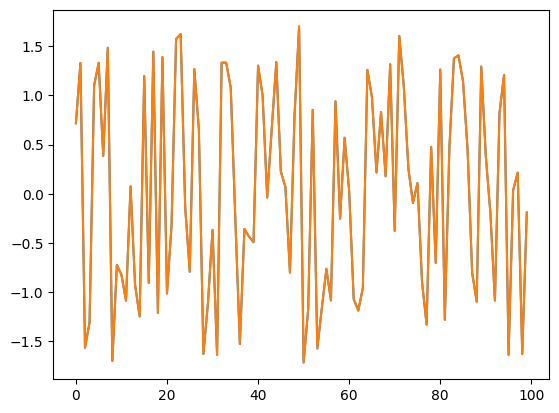

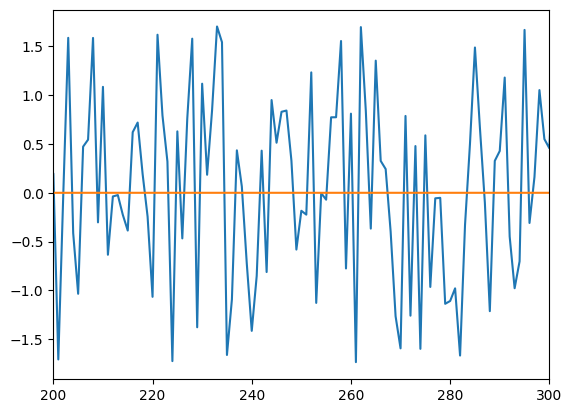

In [18]:
plt.figure()
plt.plot(y_train)
plt.plot(mu_tr)
# plt.xlim((200,300))

plt.figure()
plt.plot(y_test)
plt.plot(mu_tst)
plt.xlim((200,300))

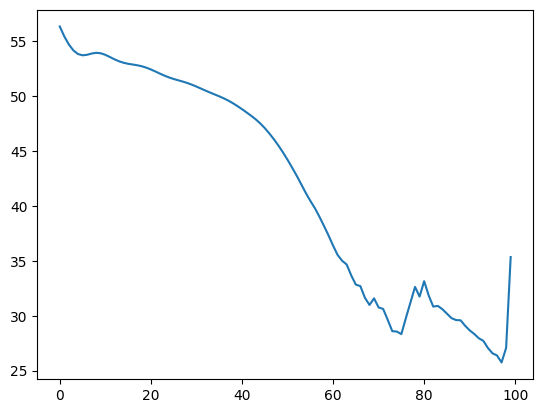

In [19]:
plt.plot(losses)

In [20]:
# print("Optimized Length Scales:", length_scales)
# print("Optimized Variances:", variances)
# print("Optimized Noises:", noises)
# print("Optimized Weights:", weights)  

## Without pre-projections

In [21]:
# ======================================================= #
# ================ (2) WITH projections  ================ #
# ======================================================= #
def loo_cv_objective_2(params, X, y, M,proj_dim, normalize_weights=False, proj_seed = 42):
    N,DIM = X.shape

    length_scales_raw = lax.dynamic_slice(params, (0,), (M * proj_dim,)).reshape((M,proj_dim))
    variances_raw = lax.dynamic_slice(params, (M * proj_dim,), (M,))
    noises_raw = lax.dynamic_slice(params, (M * (proj_dim + 1),), (M,))
    weights_raw = lax.dynamic_slice(params, (M * (proj_dim + 2),), (M,))
  
    length_scales, variances, noises = transform(length_scales_raw), transform(variances_raw), transform(noises_raw)
    weights = transform(weights_raw)
    if normalize_weights:
        weights = weights / jnp.sum(weights)

    X_reps = jnp.tile(jnp.expand_dims(X,0), (M,1,1))
    P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   
    X_projs = vmatmul(X_reps, P_projs)
    assert X_projs.shape == (M,N,proj_dim)  
    
    def gp_loops(X,length_scale, variance, noise):
        K = kernel_matrix(X, X, length_scale, variance, noise)
        K_chol = cho_factor(K, lower=True)[0]
        alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)
        
        loo_means = y - alpha / diag_inv_K
        loo_vars = 1 / diag_inv_K
        
        return loo_means, loo_vars
    
    loo_means, loo_vars = vmap(gp_loops)(X_projs,length_scales, variances, noises)  # We also map over training inputs
    
    # Fuse the means and variances using the product rule with weights
    weighted_vars_inv = weights[:, None] / loo_vars
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * loo_means, axis=0)
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(fused_vars.squeeze()) + \
                                      (y.squeeze() - fused_means.squeeze())**2 / fused_vars.squeeze())
    
    return -loo_cv_log_score  # Negative for minimization
loo_cv_objective_2_jit = jit(loo_cv_objective_2, static_argnames=['M','proj_dim',"normalize_weights"])


In [50]:
M=20
proj_dim = DIM//20
proj_seed = 20
init_params = jnp.concatenate(
    (
        0.5*jnp.ones((M * proj_dim,)),      # lengthscales
        1.0*jnp.ones((M,)),                 # variances
        0.2*jnp.ones((M,)),                 # noises
        jnp.ones((M,)),                     # weights
        ),                   
)
init_params = inv_transform(init_params)
other_params = {'X': X_train, 
                'y': y_train, 
                'M': M, 
                'proj_dim': proj_dim, 
                'normalize_weights': True,
                'proj_seed': proj_seed,
                }
static_argnames=['M', 'proj_dim', 'normalize_weights']

optimized_params,losses = optimize_objective(loo_cv_objective_2_jit,init_params,static_argnames,**other_params,
                                             lr=0.1,num_steps=300)

# Get the optimized parameters
optimized_params = transform(optimized_params)

length_scales = optimized_params[:M * proj_dim].reshape((M, proj_dim))
variances = optimized_params[M * proj_dim:M * (proj_dim + 1)]
noises = optimized_params[M * (proj_dim + 1):M * (proj_dim + 2)]
weights = optimized_params[-M:]  
if other_params["normalize_weights"]:
    weights = weights / jnp.sum(weights)

# print("Optimized Length Scales:", length_scales)
# print("Optimized Variances:", variances)
# print("Optimized Noises:", noises)
# print("Optimized Weights:", weights)

100%|██████████| 300/300 [01:16<00:00,  3.94it/s]


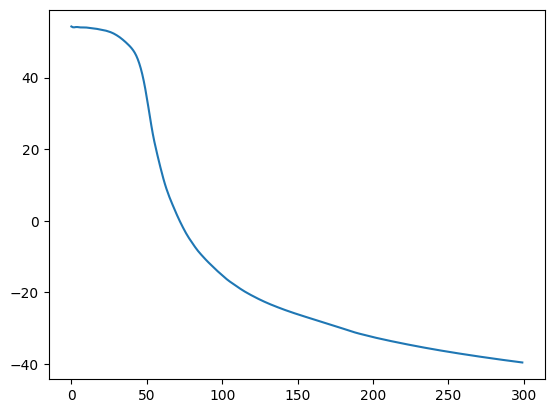

In [51]:
plt.plot(losses)

In [52]:
N,DIM = X_train.shape

X_reps = jnp.tile(jnp.expand_dims(X_train,0), (M,1,1))
X_reps_test = jnp.tile(jnp.expand_dims(X_test,0), (M,1,1))
P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   

X_projs = vmatmul(X_reps, P_projs)
X_projs_test = vmatmul(X_reps_test, P_projs)


# Make predictions
mu_tst, var_tst = predict_fused_gp_with_projs(X_projs, y_train, X_projs_test, length_scales, variances, noises, weights)
mu_tr, var_tr = predict_fused_gp_with_projs(X_projs, y_train, X_projs, length_scales, variances, noises, weights)

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))


NLPD Train:  [-4.20827443]
NLPD Test:  [1.53968297]
RMSE Train:  6.976033347683009e-05
RMSE Test:  0.6314514588393232


(200.0, 300.0)

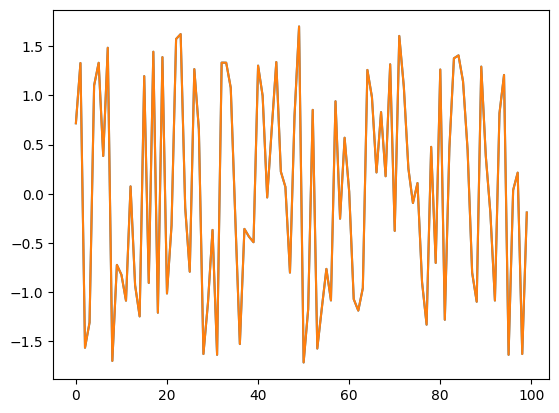

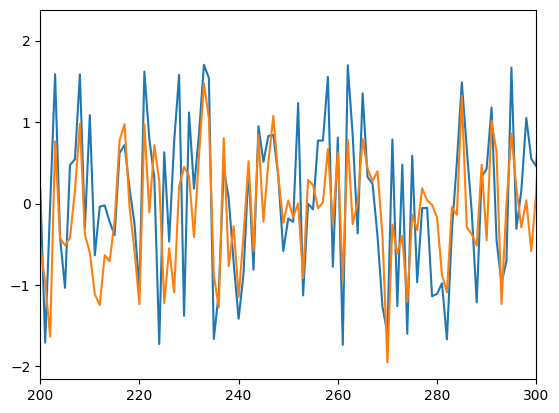

In [53]:
plt.figure()
plt.plot(y_train)
plt.plot(mu_tr)
# plt.xlim((200,300))

plt.figure()
plt.plot(y_test)
plt.plot(mu_tst)
plt.xlim((200,300))

## without projections

In [54]:
# ======================================================= #
# ============= (1) WITHOUT projections  ================ #
# ======================================================= #
def loo_cv_objective_1(params, X, y, M,dim, normalize_weights=False):
    
    length_scales_raw = lax.dynamic_slice(params, (0,), (M * dim,)).reshape((M,dim))
    variances_raw = lax.dynamic_slice(params, (M * dim,), (M,))
    noises_raw = lax.dynamic_slice(params, (M * (dim + 1),), (M,))
    weights_raw = lax.dynamic_slice(params, (M * (dim + 2),), (M,))
 
    length_scales, variances, noises = transform(length_scales_raw), transform(variances_raw), transform(noises_raw)
    weights = transform(weights_raw)
    
    if normalize_weights:
        weights = weights / jnp.sum(weights)
    
    def gp_loops(length_scale, variance, noise):
        K = kernel_matrix(X, X, length_scale, variance, noise)
        K_chol = cho_factor(K, lower=True)[0]
        alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)  # MAKE SURE y has one dimension => squeeze cabronazo!
        
        loo_means = y - alpha / diag_inv_K
        loo_vars = 1 / diag_inv_K
        
        return loo_means, loo_vars
    
    loo_means, loo_vars = vmap(gp_loops)(length_scales, variances, noises)
    
    # Fuse the means and variances using the product rule with weights
    weighted_vars_inv = weights[:, None] / loo_vars
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * loo_means, axis=0)
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(fused_vars.squeeze()) + \
                                      (y.squeeze() - fused_means.squeeze())**2 / fused_vars.squeeze())
    
    return -loo_cv_log_score  # Negative for minimization



# JIT compile the objective function for faster optimization
loo_cv_objective_1_jit = jit(loo_cv_objective_1, static_argnames=['M','dim',"normalize_weights"])

In [55]:
%%script true  
M = 10  # Number of GPs
DIM = X_train.shape[1]

# Initial parameters: length_scale, variance, noise, weights (they have to be positive!)
init_params = jnp.concatenate(
(
    # 0.1*jnp.ones((D,)), 0.5*jnp.ones((D,)), 1*jnp.ones((D,)),
    1.0 - 1.0*jax.random.uniform(jax.random.PRNGKey(42), (M*DIM,)) ,
    # 0.1*jnp.ones((M*D,)),
    1.0*jnp.ones((M,)),
    0.5*jnp.ones((M,)),
    jnp.ones((M,))
    )
)
init_params = inv_transform(init_params)
static_argnames = ['M', 'dim', 'normalize_weights']
other_params = {'X': X_train, 
                'y': y_train, 
                'M': M, 
                'dim': DIM, 
                'normalize_weights': True,
                }

optimized_params,losses = optimize_objective(loo_cv_objective_1_jit,init_params,static_argnames,**other_params,
                                             lr=0.1,num_steps=100)

# get the optimized parameters
optimized_params = transform(optimized_params)

length_scales = optimized_params[:M * DIM].reshape((M, DIM))
variances = optimized_params[M * DIM:M * (DIM + 1)]
noises = optimized_params[M * (DIM + 1):M * (DIM + 2)]
weights = optimized_params[-M:]  # Get the weights as they are 
if other_params["normalize_weights"]:
    weights = weights / jnp.sum(weights)

print("Optimized Length Scales:", length_scales)
print("Optimized Variances:", variances)
print("Optimized Noises:", noises)
print("Optimized Weights:", weights)

In [56]:
%%script true
plt.plot(losses)

In [57]:
%%script true   # esto es lo que peta
def predict_fused_gp(X_train, y_train, X_test, length_scales, variances, noises, weights):
    def gp_predict(length_scale, variance, noise):
        K = kernel_matrix(X_train, X_train, length_scale, variance, noise)
        K_s = kernel_matrix(X_test, X_train, length_scale, variance, noise, include_noise=False)
        K_ss = kernel_matrix(X_test, X_test, length_scale, variance, noise)
        
        K_chol = cho_factor(K, lower=True)[0]
        
        alpha = cho_solve((K_chol, True), y_train)
        v = cho_solve((K_chol, True), K_s.T)
        
        mu_s = K_s @ alpha
        cov_s = K_ss - K_s @ v
        
        return mu_s, jnp.diag(cov_s)
    
    mus, covs = vmap(gp_predict)(length_scales, variances, noises) 
    
    weighted_vars_inv = weights[:, None] / covs
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * mus, axis=0)
    
    return fused_means, fused_vars, mus, covs




# Make predictions
mu_tst, var_tst,_,_ = predict_fused_gp(X_train, y_train, X_test, length_scales, variances, noises, weights)
mu_tr, var_tr,_,_ = predict_fused_gp(X_train, y_train, X_train, length_scales, variances, noises, weights)

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

# Ind stacking with rand projs

In [58]:
from modules.model_training import train_and_predict_batched_gp
from modules.fusion_methods import product_fusion
from collections import defaultdict


In [59]:
results = defaultdict(lambda: {"nlpd": [], "rmse": []})

configs = [
    {'weighting': 'uniform', 'method': 'gPoE', 'normalize': True},
    {'weighting': 'entropy', 'method': 'gPoE', 'normalize': True},
    {'weighting': 'entropy', 'method': 'gPoE', 'normalize': False},
    # {'weighting': 'entropy', 'method': 'rBCM', 'normalize': False}
]

num_projections = 20
project_dim = DIM//20

mean_experts = []
std_experts = []
std_experts_prior = []

proj_seed = 20
P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (num_projections,DIM, proj_dim))/jnp.sqrt(project_dim)   

X_train_batched = np.matmul(X_train,P_projs)
X_test_batched = np.matmul(X_test,P_projs)
y_train_batched = np.tile(y_train[None,:],(num_projections,1))



# train all the experts in batch mode
preds, preds_prior,loss_vals = train_and_predict_batched_gp(X_train_batched, 
                                                    y_train_batched, 
                                                    X_test_batched,
                                                    training_iter=1000, 
                                                    lr=0.01)


mean_experts = preds.mean.numpy().T
std_experts = np.sqrt(preds.variance.numpy().T)
std_experts_prior = np.sqrt(preds_prior.variance.numpy().T)

for config in configs:
    mean_fused, std_fused, _ = product_fusion(mean_experts,
                                                std_experts,
                                                std_experts_prior,
                                                weighting=config["weighting"],
                                                normalize=config["normalize"],
                                                method=config["method"])

    nlpd_now = compute_neg_log_like(mean_fused, std_fused, y_test).squeeze()
    rmse_now = np.sqrt(np.mean((mean_fused.squeeze() - y_test.squeeze())**2))

    # Store the results
    config_key = f'{config["method"]}_{config["weighting"]}_normalize_{config["normalize"]}'
    results[config_key]["nlpd"].append(nlpd_now)
    results[config_key]["rmse"].append(rmse_now)

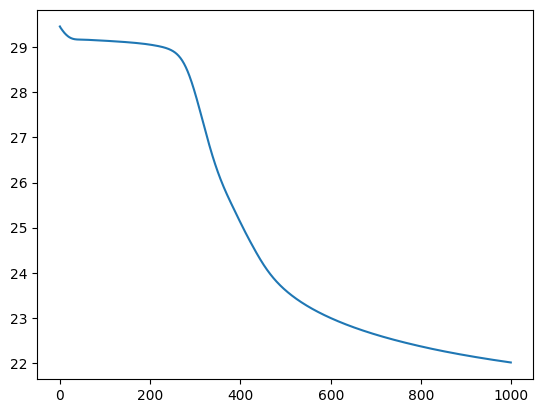

In [60]:
plt.plot(loss_vals)

In [61]:
results["gPoE_entropy_normalize_True"]["rmse"], results["gPoE_entropy_normalize_True"]['nlpd']

([0.5000283490912688], [array(0.81850954)])

In [62]:
results["gPoE_entropy_normalize_False"]["rmse"], results["gPoE_entropy_normalize_False"]['nlpd']

([0.5000283490912687], [array(1.22489328)])

In [63]:
results["gPoE_uniform_normalize_True"]["rmse"], results["gPoE_uniform_normalize_True"]['nlpd']

([0.5054019398028443], [array(0.82943957)])

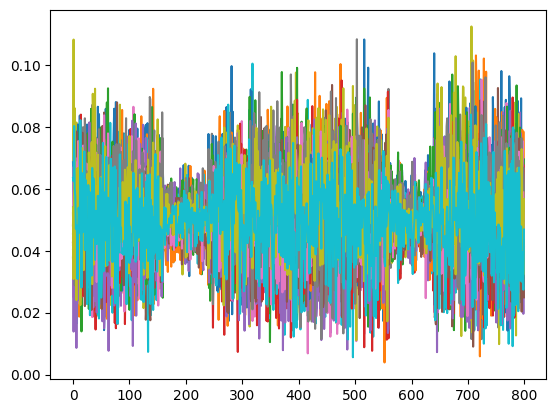

In [64]:
for i in range(num_projections):
    plt.plot(np.divide(_,_.sum(1,keepdims=True))[:,i])

# Delbridge's

In [65]:
import gpytorch
from gpytorch.metrics import mean_squared_error, mean_standardized_log_loss

In [113]:
class Delbridges(gpytorch.models.ExactGP):
    r"""
    Additive kernel (max_order = 1) on projected blocks with learned pre-projection lengthscales.
    The projected blocks are obtained by projecting X_train using random P_projs, which is 
    num_projs-by-DIM-by-proj_dim.
    """
    def __init__(self, X_train, y_train, P_projs):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        num_projs, d, proj_dim = P_projs.shape
        assert X_train.shape[1] == d

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_projs]), ard_num_dims=proj_dim),
            batch_shape = torch.Size([num_projs]),
        )
        self.P_projs = P_projs
        self.pre_lengthscales = torch.nn.Parameter(
            1.0*torch.ones((d,))    # pre-projection lengthscales
        )

    def forward(self, X):
        mean = self.mean_module(X)
        batched_X = torch.matmul(X/self.pre_lengthscales,self.P_projs) # num_projs, N, proj_dim  

        covar = self.covar_module(batched_X).sum(dim=-3)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [67]:
M=20
proj_dim = DIM // 20
P_projs = jax.random.normal(jax.random.PRNGKey(20), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)
P_projs = np.array(P_projs)

model = Delbridges(to_torch(X_train), to_torch(y_train), to_torch(P_projs))

optimizer = torch.optim.Adam( model.parameters(), lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

training_iterations = 1000
loss_vals = []
for i in tqdm(range(training_iterations)):
    optimizer.zero_grad()
    output = model(to_torch(X_train))
    gp_loss = -mll(output, to_torch(y_train))
    # l1_loss = torch.linalg.matrix_norm(model.P_projs, ord=1).sum()
    loss = gp_loss #+ 1 * l1_loss
    loss.backward()
    optimizer.step()
    loss_vals.append(loss.item())
        

model.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = model.likelihood(model(to_torch(X_test)))
        preds_train = model.likelihood(model(to_torch(X_train)))


print("NLPD train: ", mean_standardized_log_loss(preds_train,to_torch(y_train)).numpy())      
print("NLPD test: ", mean_standardized_log_loss(preds,to_torch(y_test)).numpy())  

print("RMSE train: ", np.sqrt(mean_squared_error(preds_train, to_torch(y_train)).numpy()))
print("RMSE test: ", np.sqrt(mean_squared_error(preds, to_torch(y_test)).numpy()))

100%|██████████| 1000/1000 [00:07<00:00, 131.47it/s]


NLPD train:  -3.4431357264042175
NLPD test:  1013.3081525900794
RMSE train:  0.0009976068972992725
RMSE test:  0.876824947433306


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


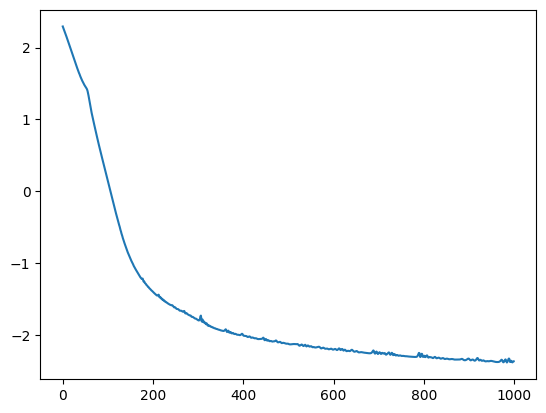

In [68]:
plt.plot(loss_vals)

# comparisons

In [80]:
import imageio.v2 as imageio

X_train_all = []
for i in 1+np.arange(12000):
    img = imageio.imread(f"/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_train/{i}.jpg")
    X_train_all.append(img)

X_train_all = np.array(X_train_all)    
X_train_all = X_train_all.reshape(12000,28*28)

X_test = []
for i in 1+np.arange(800):
    img = imageio.imread(f"/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_test/{i}.jpg")
    X_test.append(img)

X_test = np.array(X_test)    
X_test = X_test.reshape(800,28*28)


In [81]:
import pandas as pd

file = "/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_train/train_list.txt"
df = pd.read_csv(file, header=None, delimiter=' ') # or quotechar = "'"
y_train_all = np.array(df[1])

file = "/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_test/test_list.txt"
df = pd.read_csv(file, header=None, delimiter=' ') # or quotechar = "'"
y_test = np.array(df[1])

In [82]:
X_train_all = X_train_all/255.0 
X_test = X_test/255.0 

In [83]:
mean_y = np.mean(y_train_all)
std_y = np.std(y_train_all)

y_train_all = (y_train_all - mean_y)/std_y
y_test = (y_test - mean_y)/std_y

In [92]:
# select a small subset of the training data
np.random.seed(666)
indices = np.random.choice(len(X_train_all),100)
X_train = X_train_all[indices]
y_train = y_train_all[indices]
X_train.shape,y_train.shape

((100, 784), (100,))

In [173]:
data_dict = {
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
}

## Baselines

In [172]:
# standard GPs 
class GPModel(gpytorch.models.ExactGP):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    def __init__(self, train_x, train_y, kernel=None, mean=None):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean or gpytorch.means.ConstantMean()
        self.covar_module = kernel or gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

def predict_with_model(model, data_dict, training_iters = 1000, lr = 0.01):
    r"""
    Train an exact GP on the environment variables (X_train,y_train) and evaluate on (X_test,y_test)
    """
    optimizer = torch.optim.Adam( model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    model.train()
    loss_vals = []
    for i in tqdm(range(training_iters)):
        optimizer.zero_grad()
        output = model(to_torch(data_dict["X_train"]))
        loss = -mll(output, to_torch(data_dict["y_train"]))  
        loss.backward()
        optimizer.step()
        loss_vals.append(loss.item())
            

    model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
            preds = model.likelihood(model(to_torch(data_dict["X_test"])))
            preds_train = model.likelihood(model(to_torch(data_dict["X_train"])))     
    
    results = {"rmse": {}, "mll": {}}
    results["rmse"]["train"] = np.sqrt(mean_squared_error(preds_train,to_torch(data_dict["y_train"])).numpy())
    results["rmse"]["test"] = np.sqrt(mean_squared_error(preds,to_torch(data_dict["y_test"])).numpy())    
    results["mll"]["train"] = mean_standardized_log_loss(preds_train,to_torch(data_dict["y_train"])).numpy()
    results["mll"]["test"] = mean_standardized_log_loss(preds,to_torch(data_dict["y_test"])).numpy()

    return results, loss_vals


In [141]:
# rbf gp
model = GPModel(to_torch(X_train),to_torch(y_train))
results_rbf, loss_rbf = predict_with_model(model,data_dict,training_iters=300,lr=0.1)

# gam gp
kernel = AdditiveStructureKernel(base_kernel=ScaleKernel(RBFKernel()), num_dims=X_train.shape[1])
model = GPModel(to_torch(X_train),to_torch(y_train),kernel=kernel)
results_gam, loss_gam = predict_with_model(model,data_dict,training_iters=300,lr=0.1)


100%|██████████| 300/300 [00:15<00:00, 19.50it/s]


RBF (rmse, mll):  0.5691247300124018 1.0335930338132084
GAM (rmse, mll):  0.5565421047747979 1.0406223478122476


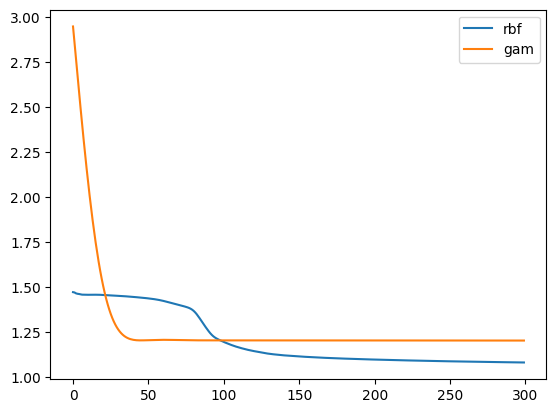

In [142]:
print("RBF (rmse, mll): ",results_rbf["rmse"]["test"], results_rbf["mll"]["test"])
print("GAM (rmse, mll): ",results_gam["rmse"]["test"], results_gam["mll"]["test"])


plt.plot(loss_rbf, label = "rbf")
plt.plot(loss_gam, label = "gam")
plt.legend();

## Stack projected GPs

### Joint learning

In [174]:
def stack_proj_gps_joint(M,proj_dim,proj_seed,data_dict,lr=0.1,num_steps=300):
    r"""
    Learn jointly the hyperparameters of M exact projected GPs and product fusion weights using LOO loss.
    The projected GPs are obtained by projecting X_train using M random DIM-by-proj_dim projection matrices.
    It uses the environment variables (X_train,y_train) and evaluates on (X_test,y_test).
    """

    X_train = data_dict["X_train"]
    y_train = data_dict["y_train"]
    X_test = data_dict["X_test"]
    y_test = data_dict["y_test"]

    init_params = jnp.concatenate(
        (
            0.5*jnp.ones((M * proj_dim,)),      # lengthscales
            1.0*jnp.ones((M,)),                 # variances
            0.2*jnp.ones((M,)),                 # noises
            jnp.ones((M,)),                     # weights
            ),                   
    )
    init_params = inv_transform(init_params)
    other_params = {'X': X_train, 
                    'y': y_train, 
                    'M': M, 
                    'proj_dim': proj_dim, 
                    'normalize_weights': True,
                    'proj_seed': proj_seed,
                    }
    static_argnames=['M', 'proj_dim', 'normalize_weights']

    # Train
    optimized_params,losses = optimize_objective(loo_cv_objective_2_jit,init_params,static_argnames,**other_params,
                                                lr=lr,num_steps=num_steps)

    # Get the optimized parameters
    optimized_params = transform(optimized_params)

    length_scales = optimized_params[:M * proj_dim].reshape((M, proj_dim))
    variances = optimized_params[M * proj_dim:M * (proj_dim + 1)]
    noises = optimized_params[M * (proj_dim + 1):M * (proj_dim + 2)]
    weights = optimized_params[-M:]  
    if other_params["normalize_weights"]:
        weights = weights / jnp.sum(weights)


    # Predict
    P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   
    X_projs = jnp.matmul(X_train, P_projs)
    X_projs_test = jnp.matmul(X_test, P_projs)

    # Make predictions
    mu_tst, var_tst = predict_fused_gp_with_projs(X_projs, y_train, X_projs_test, length_scales, variances, noises, weights)
    mu_tr, var_tr = predict_fused_gp_with_projs(X_projs, y_train, X_projs, length_scales, variances, noises, weights)

    results_joint = {"rmse": {}, "mll": {}}

    results_joint["mll"]["train"] = compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train)
    results_joint["mll"]["test"] = compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test)

    results_joint["rmse"]["train"] = jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) )
    results_joint["rmse"]["test"] = jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) )

    return results_joint, losses


M=20
proj_dim = DIM//20
proj_seed = 20
results_joint, losses = stack_proj_gps_joint(M,proj_dim,proj_seed, data_dict,num_steps=300,lr=0.1)

  3%|▎         | 10/300 [00:04<02:21,  2.04it/s]


KeyboardInterrupt: 

Joint  (rmse, mll):  0.5446750583106302 [1.31729513]


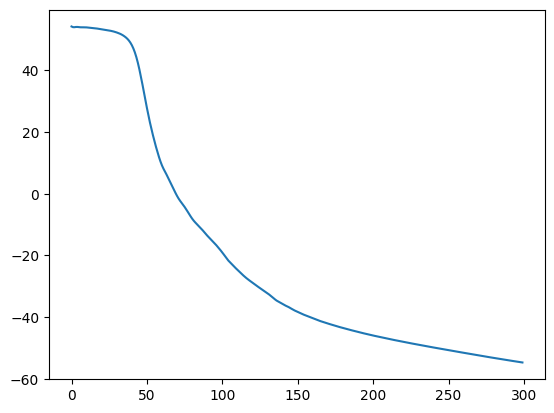

In [144]:
print("Joint  (rmse, mll): ",results_joint["rmse"]["test"], results_joint["mll"]["test"])
plt.plot(losses)

### ind learning

In [277]:
def stack_proj_gps_ind(num_projections,project_dim,proj_seed,data_dict,training_iter=100,lr=0.1):
    r"""
    Learn the hyperparameters of num_projections independent exact projected GPs. The weights are obtained by
    a fixed formula or set uniform. The projected GPs are obtained by projecting X_train using num_projections 
    random DIM-by-project_dim projection matrices. 
    It uses the enviroment variables (X_train,y_train) and evaluates on (X_test,y_test)
    """
    X_train = data_dict["X_train"]
    y_train = data_dict["y_train"]
    X_test = data_dict["X_test"]
    y_test = data_dict["y_test"]

    configs = [
        {'weighting': 'uniform', 'method': 'gPoE', 'normalize': True},
        {'weighting': 'entropy', 'method': 'gPoE', 'normalize': True},
        {'weighting': 'entropy', 'method': 'gPoE', 'normalize': False},
        # {'weighting': 'entropy', 'method': 'rBCM', 'normalize': False}
    ]

    mean_experts = []
    std_experts = []
    std_experts_prior = []


    P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (num_projections,DIM, proj_dim))/jnp.sqrt(project_dim)   

    X_train_batched = np.matmul(X_train,P_projs)
    X_test_batched = np.matmul(X_test,P_projs)
    y_train_batched = np.tile(y_train[None,:],(num_projections,1))


    # train all the experts in batch mode
    preds, preds_prior,loss_vals = train_and_predict_batched_gp(X_train_batched, 
                                                        y_train_batched, 
                                                        X_test_batched,
                                                        training_iter=training_iter, 
                                                        lr=lr)


    mean_experts = preds.mean.numpy().T
    std_experts = np.sqrt(preds.variance.numpy().T)
    std_experts_prior = np.sqrt(preds_prior.variance.numpy().T)

    results = {}
    for config in configs:
        mean_fused, std_fused, _ = product_fusion(mean_experts,
                                                    std_experts,
                                                    std_experts_prior,
                                                    weighting=config["weighting"],
                                                    normalize=config["normalize"],
                                                    method=config["method"])

        nlpd_now = compute_neg_log_like(mean_fused, std_fused, y_test).squeeze()
        rmse_now = np.sqrt(np.mean((mean_fused.squeeze() - y_test.squeeze())**2))

        # Store the results
        config_key = f'{config["method"]}_{config["weighting"]}_normalize_{config["normalize"]}'
        if config_key in results:
            results[config_key]["mll"].append(nlpd_now.item())
            results[config_key]["rmse"].append(rmse_now.item())
        else:
            results[config_key] = {"mll": [nlpd_now.item()], "rmse": [rmse_now.item()]}


    return results, loss_vals      

np.random.seed(678 + 1)
indices = np.random.choice(len(X_train_all),100)
X_train = X_train_all[indices]
y_train = y_train_all[indices]

data_dict = {
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
}
M = 10
project_dim = DIM//M
proj_seed = 20

data_dict 

results_ind, loss_vals_ind = stack_proj_gps_ind(M, proj_dim, proj_seed, data_dict,training_iter=500,lr=0.1)

[0.9401323503489472] [array(1.46661054)]
Indep  (rmse, mll):  [0.9666465332595928] [array(1.39118665)]

Indep  (rmse, mll):  [0.6414872969707031] [0.9782446783331277]
Indep  (rmse, mll):  [0.6441645384603175] [0.9868639513147106]


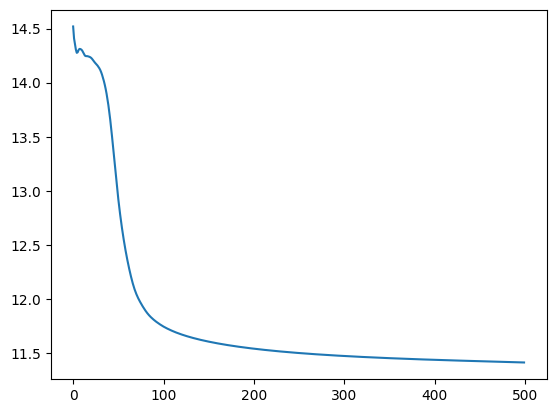

In [278]:
print("Indep  (rmse, mll): ",results_ind["gPoE_entropy_normalize_True"]["rmse"], 
      results_ind["gPoE_entropy_normalize_True"]["mll"])
print("Indep  (rmse, mll): ",results_ind["gPoE_uniform_normalize_True"]["rmse"], 
      results_ind["gPoE_uniform_normalize_True"]["mll"])
plt.plot(loss_vals_ind)

## Additive proj kernel

In [154]:
M=100
proj_dim = DIM // M
proj_seed=20
P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)
P_projs = np.array(P_projs)

model = Delbridges(to_torch(X_train), to_torch(y_train), to_torch(P_projs))
results_delbridge, loss_delbridge = predict_with_model(model, training_iters=500,lr=0.1)


100%|██████████| 500/500 [00:06<00:00, 75.43it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


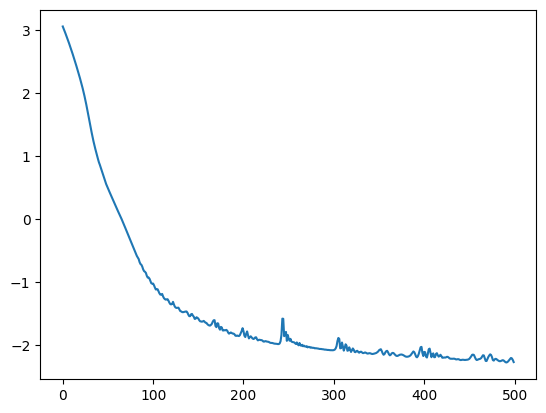

In [157]:
plt.plot(loss_delbridge)

In [158]:
print("Delbridges (rmse and mll): ", results_delbridge["rmse"]["test"],
      results_delbridge["mll"]["test"])

Delbridges (rmse and mll):  0.7605701910199586 804.1566580864513


## Comparando de una puta vez

In [178]:
def test_faces(M,proj_dim,proj_seed):

    all_results_rbf = []
    all_results_gam = []
    all_results_joint = []
    all_results_ind = []
    all_results_delbridge = []

    for i in range(5):
        print(f"Testing data split {i}")
        # select a small subset of the training data
        np.random.seed(678 + i)
        indices = np.random.choice(len(X_train_all),100)
        X_train = X_train_all[indices]
        y_train = y_train_all[indices]

        data_dict = {
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test,
        }

        # baselines
        model = GPModel(to_torch(X_train),to_torch(y_train))
        results_rbf, loss_rbf = predict_with_model(model,data_dict,training_iters=500,lr=0.1)
        all_results_rbf.append(results_rbf)

        kernel = AdditiveStructureKernel(base_kernel=ScaleKernel(RBFKernel()), num_dims=X_train.shape[1])
        model = GPModel(to_torch(X_train),to_torch(y_train),kernel=kernel)
        results_gam, loss_gam = predict_with_model(model,data_dict,training_iters=500,lr=0.1)
        all_results_gam.append(results_gam)

        #--- Projection methods --- #
        # (1) stacking projections (pdfs) in y-space
        # joint learning projected experts' hyperparameters and weights
        results_joint, losses = stack_proj_gps_joint(M,proj_dim,proj_seed, data_dict,num_steps=500, lr=0.1)
        all_results_joint.append(results_joint)
        # independent learning of projected experts' hyperparameters
        results_ind, losses = stack_proj_gps_ind(M,proj_dim,proj_seed,data_dict,training_iter=500, lr=0.1)  
        all_results_ind.append(results_ind)     

        
        # (2) "stacking" projections in kernel space  (se me habia olvidado definir el modelo....)
        P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,X_train.shape[1], proj_dim))/jnp.sqrt(project_dim)   
        P_projs = np.array(P_projs)
        model = Delbridges(to_torch(X_train), to_torch(y_train), to_torch(P_projs))
        results_delbridge, loss_delbridge = predict_with_model(model, data_dict,training_iters=500,lr=0.1)
        all_results_delbridge.append(results_delbridge)

    return all_results_rbf,all_results_gam,all_results_joint,all_results_ind,all_results_delbridge

In [179]:
results_dict = {}       
for M in [5,10,20,50]:          # number of projections/number of models in stacking
    print(f"Running for M={M}")
    proj_dim = DIM // M         # dimension of the projected inputs
    proj_seed=20                # seed for generating the random projection natrices

    all_results_rbf,all_results_gam,all_results_joint,all_results_ind,all_results_delbridge = test_faces(M,proj_dim,proj_seed)

    results_dict[f"{M}"] = {"rbf": all_results_rbf,
                            "gam": all_results_gam,
                            "joint": all_results_joint,
                            "ind": all_results_ind,
                            "delbridge": all_results_delbridge,
                            }
    
    


Running for M=5
Testing data split 0


100%|██████████| 500/500 [00:26<00:00, 18.70it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 1


100%|██████████| 500/500 [00:28<00:00, 17.79it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 2


100%|██████████| 500/500 [00:28<00:00, 17.62it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 3


100%|██████████| 500/500 [00:27<00:00, 17.88it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 4


100%|██████████| 500/500 [00:27<00:00, 18.03it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Running for M=10
Testing data split 0


100%|██████████| 500/500 [00:28<00:00, 17.84it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 1


100%|██████████| 500/500 [00:27<00:00, 18.28it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 2


100%|██████████| 500/500 [00:28<00:00, 17.76it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 3


100%|██████████| 500/500 [00:27<00:00, 18.34it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 4


100%|██████████| 500/500 [00:27<00:00, 17.88it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Running for M=20
Testing data split 0


100%|██████████| 500/500 [00:27<00:00, 18.29it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 1


100%|██████████| 500/500 [00:27<00:00, 18.32it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 2


100%|██████████| 500/500 [00:27<00:00, 18.10it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 3


100%|██████████| 500/500 [00:27<00:00, 18.04it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 4


100%|██████████| 500/500 [00:27<00:00, 18.22it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Running for M=50
Testing data split 0


100%|██████████| 500/500 [00:26<00:00, 19.01it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 1


100%|██████████| 500/500 [00:27<00:00, 18.22it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 2


100%|██████████| 500/500 [00:27<00:00, 18.16it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 3


100%|██████████| 500/500 [00:27<00:00, 18.22it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 4


100%|██████████| 500/500 [00:27<00:00, 18.15it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [290]:
# import pickle
# with open('results_dict_copy.pickle', 'wb') as handle:
#     pickle.dump(results_dict_copy, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [227]:
# results_dict_copy = results_dict

In [233]:
# for M in [5,10,20,50]:
#     for j in range(5):
#         results_dict_copy[f"{M}"]["ind"][j] = dict(results_dict[f"{M}"]["ind"][i])

In [259]:
results_dict["50"]["ind"]

[{'gPoE_uniform_normalize_True': {'mll': [array(1.38272597)],
   'rmse': [0.9349421598643506]},
  'gPoE_entropy_normalize_True': {'mll': [array(1.39595347)],
   'rmse': [0.868005287740108]},
  'gPoE_entropy_normalize_False': {'mll': [array(6.16498983)],
   'rmse': [0.868005287740108]}},
 {'gPoE_uniform_normalize_True': {'mll': [array(1.38272597)],
   'rmse': [0.9349421598643506]},
  'gPoE_entropy_normalize_True': {'mll': [array(1.39595347)],
   'rmse': [0.868005287740108]},
  'gPoE_entropy_normalize_False': {'mll': [array(6.16498983)],
   'rmse': [0.868005287740108]}},
 {'gPoE_uniform_normalize_True': {'mll': [array(1.38272597)],
   'rmse': [0.9349421598643506]},
  'gPoE_entropy_normalize_True': {'mll': [array(1.39595347)],
   'rmse': [0.868005287740108]},
  'gPoE_entropy_normalize_False': {'mll': [array(6.16498983)],
   'rmse': [0.868005287740108]}},
 {'gPoE_uniform_normalize_True': {'mll': [array(1.38272597)],
   'rmse': [0.9349421598643506]},
  'gPoE_entropy_normalize_True': {'mll':

### plot

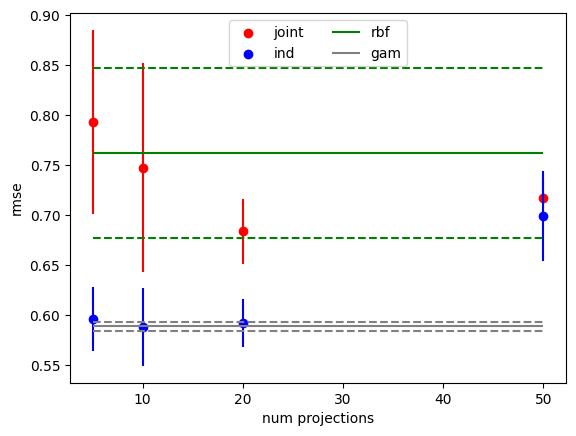

In [306]:
error_measure = "rmse"

rbf_results = []
gam_results = []
for i in range(5):
        # rbf_results.append(results_dict_copy["5"]["rbf"][i][error_measure]["test"])
        # gam_results.append(results_dict_copy["5"]["gam"][i][error_measure]["test"])

        rbf_results.append(all_results_rbf[i][error_measure]["test"])
        gam_results.append(all_results_gam[i][error_measure]["test"])

rbf_results = np.array(rbf_results)
gam_results = np.array(gam_results)

for M in [5,10,20,50]:
    joint_results = []
    ind_results = []
    del_results = []
    for i in range(5):
            joint_results.append(results_dict_copy[f"{M}"]["joint"][i][error_measure]["test"])
            ind_results.append(results_dict_copy[f"{M}"]["ind"][i]["gPoE_entropy_normalize_True"][error_measure])
            del_results.append(results_dict_copy[f"{M}"]["delbridge"][i][error_measure]["test"])
        #     ind_results.append(solo_ind_dict[f"{M}"]["ind"][i]["gPoE_entropy_normalize_True"][error_measure])
        #     del_results.append(solo_delbridge_dict[f"{M}"]["delbridge"][i][error_measure]["test"])

    joint_results = np.array(joint_results)
    ind_results = np.array(ind_results)
    del_results = np.array(del_results)
    if M == 5:
        plt.scatter(M,np.nanmean(joint_results),color = "red", label = "joint")
        plt.errorbar(M,np.nanmean(joint_results),np.nanstd(joint_results)/np.sqrt(np.sum(1-np.isnan(joint_results))),color = "red")

        plt.scatter(M,np.nanmean(ind_results),color = "blue", label = "ind")
        plt.errorbar(M,np.nanmean(ind_results),np.nanstd(ind_results)/np.sqrt(np.sum(1-np.isnan(ind_results))),color = "blue")
        
        # plt.scatter(M,np.nanmean(del_results),color = "magenta", label = "delbridge")
        # plt.errorbar(M,np.nanmean(del_results),np.nanstd(del_results)/np.sqrt(np.sum(1-np.isnan(del_results))),color = "magenta")
    else:
        plt.scatter(M,np.nanmean(joint_results),color = "red")
        plt.errorbar(M,np.nanmean(joint_results),np.nanstd(joint_results)/np.sqrt(np.sum(1-np.isnan(joint_results))),color = "red")

        plt.scatter(M,np.nanmean(ind_results),color = "blue")  
        plt.errorbar(M,np.nanmean(ind_results),np.nanstd(ind_results)/np.sqrt(np.sum(1-np.isnan(ind_results))),color = "blue")

        # plt.scatter(M,np.nanmean(del_results),color = "magenta")
        # plt.errorbar(M,np.nanmean(del_results),np.nanstd(del_results)/np.sqrt(np.sum(1-np.isnan(del_results))),color = "magenta")

plt.hlines(rbf_results.mean(),5,50, label = "rbf", color = "green") 
plt.hlines(rbf_results.mean()+np.std(rbf_results)/np.sqrt(np.sum(1-np.isnan(rbf_results))),5,50, color = "green",linestyles="dashed")     
plt.hlines(rbf_results.mean()-np.std(rbf_results)/np.sqrt(np.sum(1-np.isnan(rbf_results))),5,50,  color = "green",linestyles="dashed")     

plt.hlines(gam_results.mean(),5,50, label = "gam", color = "grey")   
plt.hlines(gam_results.mean()+np.std(gam_results)/np.sqrt(np.sum(1-np.isnan(gam_results))),5,50, color = "grey",linestyles="dashed")     
plt.hlines(gam_results.mean()-np.std(gam_results)/np.sqrt(np.sum(1-np.isnan(gam_results))),5,50,  color = "grey",linestyles="dashed")     

# plt.yscale("log")
plt.xlabel("num projections")
plt.ylabel(error_measure)
plt.legend(loc='upper center',ncols = 2)

In [266]:
results_dict["10"]["ind"][0]["gPoE_entropy_normalize_True"],results_dict["10"]["ind"][1]["gPoE_entropy_normalize_True"]

({'mll': [array(1.13686555)], 'rmse': [0.6572800964161042]},
 {'mll': [array(1.13686555)], 'rmse': [0.6572800964161042]})

Solo Simus de Delbridge

In [285]:
solo_delbridge_dict = {}       
for M in [5,10,20,50]:          # number of projections/number of models in stacking
    print(f"Running for M={M}")
    proj_dim = DIM // M         # dimension of the projected inputs
    proj_seed=20                # seed for generating the random projection natrices

    def test_solo_delbridge(M,proj_dim,proj_seed):
        all_results_delbridge = []
        for i in range(5):
            print(f"Testing data split {i}")
            # select a small subset of the training data
            np.random.seed(678 + i)
            indices = np.random.choice(len(X_train_all),100)
            X_train = X_train_all[indices]
            y_train = y_train_all[indices]

            data_dict = {
                "X_train": X_train,
                "y_train": y_train,
                "X_test": X_test,
                "y_test": y_test,
            }
            
            # (2) "stacking" projections in kernel space  (se me habia olvidado definir el modelo....)
            P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,X_train.shape[1], proj_dim))/jnp.sqrt(project_dim)   
            P_projs = np.array(P_projs)
            model = Delbridges(to_torch(X_train), to_torch(y_train), to_torch(P_projs))
            results_delbridge, loss_delbridge = predict_with_model(model, data_dict,training_iters=1000,lr=0.01)
            all_results_delbridge.append(results_delbridge)

        return all_results_delbridge

    all_results_delbridge = test_solo_delbridge(M,proj_dim,proj_seed)
    solo_delbridge_dict[f"{M}"] = {
                            "delbridge": all_results_delbridge,
                            }
    

Running for M=5
Testing data split 0


100%|██████████| 1000/1000 [00:07<00:00, 130.22it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Testing data split 1


100%|██████████| 1000/1000 [00:07<00:00, 135.73it/s]


Testing data split 2


100%|██████████| 1000/1000 [00:07<00:00, 131.70it/s]


Testing data split 3


100%|██████████| 1000/1000 [00:07<00:00, 138.63it/s]


Testing data split 4


100%|██████████| 1000/1000 [00:06<00:00, 151.08it/s]


Running for M=10
Testing data split 0


100%|██████████| 1000/1000 [00:07<00:00, 130.72it/s]


Testing data split 1


100%|██████████| 1000/1000 [00:08<00:00, 119.03it/s]


Testing data split 2


100%|██████████| 1000/1000 [00:07<00:00, 130.31it/s]


Testing data split 3


100%|██████████| 1000/1000 [00:07<00:00, 130.13it/s]


Testing data split 4


100%|██████████| 1000/1000 [00:07<00:00, 130.22it/s]


Running for M=20
Testing data split 0


100%|██████████| 1000/1000 [00:08<00:00, 113.10it/s]


Testing data split 1


100%|██████████| 1000/1000 [00:08<00:00, 120.39it/s]


Testing data split 2


100%|██████████| 1000/1000 [00:08<00:00, 117.64it/s]


Testing data split 3


100%|██████████| 1000/1000 [00:08<00:00, 117.35it/s]


Testing data split 4


100%|██████████| 1000/1000 [00:08<00:00, 112.62it/s]


Running for M=50
Testing data split 0


100%|██████████| 1000/1000 [00:11<00:00, 87.95it/s]


Testing data split 1


100%|██████████| 1000/1000 [00:10<00:00, 97.20it/s]


Testing data split 2


100%|██████████| 1000/1000 [00:10<00:00, 98.09it/s]


Testing data split 3


100%|██████████| 1000/1000 [00:09<00:00, 101.44it/s]


Testing data split 4


100%|██████████| 1000/1000 [00:10<00:00, 99.15it/s]


In [263]:
solo_delbridge_dict["10"]["delbridge"]

[{'rmse': {'train': 0.00010636874615383924, 'test': 1.0179843428082251},
  'mll': {'train': array(-3.33748251), 'test': array(1.44271798)}},
 {'rmse': {'train': 0.09186599303020038, 'test': 1.0050913638928038},
  'mll': {'train': array(0.07709563), 'test': array(1.42403639)}},
 {'rmse': {'train': 0.08932069182364344, 'test': 1.004325380375847},
  'mll': {'train': array(0.0489696), 'test': array(1.42379087)}},
 {'rmse': {'train': 9.895845594814672e-05, 'test': 1.019890396359135},
  'mll': {'train': array(-3.31717586), 'test': array(1.43953781)}},
 {'rmse': {'train': 0.08655449623206399, 'test': 1.005207518131359},
  'mll': {'train': array(0.01747699), 'test': array(1.42731648)}}]

Solo ind


In [280]:
solo_ind_dict = {}       
for M in [5,10,20,50]:          # number of projections/number of models in stacking
    print(f"Running for M={M}")
    proj_dim = DIM // M         # dimension of the projected inputs
    proj_seed=20                # seed for generating the random projection natrices

    def test_solo_ind(M,proj_dim,proj_seed):
        all_results_ind = []
        for i in range(5):
            print(f"Testing data split {i}")
            # select a small subset of the training data
            np.random.seed(678 + i)
            indices = np.random.choice(len(X_train_all),100)
            X_train = X_train_all[indices]
            y_train = y_train_all[indices]

            data_dict = {
                "X_train": X_train,
                "y_train": y_train,
                "X_test": X_test,
                "y_test": y_test,
            }
  
            # independent learning of projected experts' hyperparameters
            results_ind, losses = stack_proj_gps_ind(M,proj_dim,proj_seed,data_dict,training_iter=500, lr=0.1)  
            all_results_ind.append(results_ind)     
        return all_results_ind

    all_results_ind = test_solo_ind(M,proj_dim,proj_seed)
    solo_ind_dict[f"{M}"] = {
                            "ind": all_results_ind,
                            }

Running for M=5
Testing data split 0
Testing data split 1
Testing data split 2
Testing data split 3
Testing data split 4
Running for M=10
Testing data split 0
Testing data split 1
Testing data split 2
Testing data split 3
Testing data split 4
Running for M=20
Testing data split 0
Testing data split 1
Testing data split 2
Testing data split 3
Testing data split 4
Running for M=50
Testing data split 0
Testing data split 1
Testing data split 2
Testing data split 3
Testing data split 4


In [281]:
solo_ind_dict["10"]["ind"]

[{'gPoE_uniform_normalize_True': {'mll': [1.1690954301756569],
   'rmse': [0.7023881454471671]},
  'gPoE_entropy_normalize_True': {'mll': [1.1368655487334778],
   'rmse': [0.6572800964161042]},
  'gPoE_entropy_normalize_False': {'mll': [3.0793053912551294],
   'rmse': [0.6572800964161042]}},
 {'gPoE_uniform_normalize_True': {'mll': [0.7749371792854839],
   'rmse': [0.5198390428495494]},
  'gPoE_entropy_normalize_True': {'mll': [0.773549410084511],
   'rmse': [0.5220322185090663]},
  'gPoE_entropy_normalize_False': {'mll': [1.4277750264497002],
   'rmse': [0.5220322185090662]}},
 {'gPoE_uniform_normalize_True': {'mll': [1.2204076214759936],
   'rmse': [0.8153086205889306]},
  'gPoE_entropy_normalize_True': {'mll': [1.4788531306780288],
   'rmse': [0.7251382034673242]},
  'gPoE_entropy_normalize_False': {'mll': [1.4226120368831767],
   'rmse': [0.7251382034673242]}},
 {'gPoE_uniform_normalize_True': {'mll': [0.8912790426456368],
   'rmse': [0.5394659064068653]},
  'gPoE_entropy_normalize

In [288]:
# for M in [5,10,20,50]:

#     results_dict_copy[f"{M}"]["ind"] = solo_ind_dict[f"{M}"]["ind"]
#     results_dict_copy[f"{M}"]["delbridge"] = solo_delbridge_dict[f"{M}"]["delbridge"]

In [297]:
def test_mi_polla():
    all_results_rbf = []
    all_results_gam = []
    for i in range(5):
        print(f"Testing data split {i}")
        # select a small subset of the training data
        np.random.seed(678 + i)
        indices = np.random.choice(len(X_train_all),100)
        X_train = X_train_all[indices]
        y_train = y_train_all[indices]

        data_dict = {
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test,
        }

        # baselines
        model = GPModel(to_torch(X_train),to_torch(y_train))
        results_rbf, loss_rbf = predict_with_model(model,data_dict,training_iters=1000,lr=0.01)
        all_results_rbf.append(results_rbf)

        kernel = AdditiveStructureKernel(base_kernel=ScaleKernel(RBFKernel()), num_dims=X_train.shape[1])
        model = GPModel(to_torch(X_train),to_torch(y_train),kernel=kernel)
        results_gam, loss_gam = predict_with_model(model,data_dict,training_iters=1000,lr=0.01)
        all_results_gam.append(results_gam)


    return all_results_rbf,all_results_gam

In [298]:
all_results_rbf,all_results_gam = test_mi_polla()

Testing data split 0


100%|██████████| 1000/1000 [00:04<00:00, 234.62it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
100%|██████████| 1000/1000 [00:54<00:00, 18.26it/s]


Testing data split 1


100%|██████████| 1000/1000 [00:52<00:00, 18.99it/s]


Testing data split 2


100%|██████████| 1000/1000 [00:54<00:00, 18.42it/s]


Testing data split 3


100%|██████████| 1000/1000 [00:53<00:00, 18.77it/s]


Testing data split 4


100%|██████████| 1000/1000 [00:54<00:00, 18.46it/s]
